# Tune CAS threads for optimal performance of loadImages action

This notebook demonstrates how to use CVPy to tune CAS threads for an image action. In this demo, examples are shown which compute optimal thread count for loading natural images and dicom series. Demoed examples show usage of CAS thread optimization tool to record and plot the performance in SMP and MPP CAS architecture.

## Load python packages

In [15]:
from swat import *

## Import CVPy CAS thread tuner module

In [16]:
from cvpy.utils.CASThreadTuner import *

## Define setup function to set up CAS environment

    Returns - 
        s: CAS connection

In [17]:
def setup():
    # Connect to the CAS server
    s = CAS('your-host-name.unx.com', 5570)
    
    #  Load image actionset
    s.loadactionset('image')

    # Add a caslib
    s.addcaslib(name='dlib',
                activeOnAdd=True,
                path='/path/to/caslib',
                dataSource='PATH',
                subdirectories=True
               )

    # Set message level to error
    s.setsessopt(messageLevel="ERROR")
    
    # return the CAS connection 
    return s

## Define teardown function to terminate the CAS session

    Parameters - 
        s: CAS connection

In [18]:
def teardown(s):
    s.close()

## Define action function that calls an image action

    Parameters - 
        s: CAS connection
        c_threads: Number of threads on controller node
        w_threads: Number of threads on worker node

    Returns -
        response.performance.elapsed_time: Time taken to perform given action.
        
We define two action functions below.

In [5]:
# 1. Load natural images
def load_natural_images(s, c_threads, w_threads):
    image_table = s.CASTable("image_table", replace=True)
    
    # Call loadImages action and store the performance in response variable.
    response = s.image.loadimages(
            casout=image_table,
            path = 'DemoData/ThreadTunerData/Natural',
            caslib='dlib',
        
            # Following 2 threads parameters are mandatory and are set equal to input arguments.
            nControllerThreads = c_threads,
            nThreads = w_threads
        )
    
    return response.performance.elapsed_time

In [19]:
# 2. Load dicom series
def load_dicom_series(s, c_threads, w_threads):
    image_table = s.CASTable("image_table", replace=True)
    
    # Call loadImages action and store the performance in response variable.
    response = s.image.loadimages(
            casout=image_table,
            path = 'DemoData/ThreadTunerData/DICOM',
            caslib='dlib',
            decode = True,
            series=vl(dicom=True),
            recurse = True,
        
            # Following 2 threads parameters are mandatory and are set equal to input arguments.
            nControllerThreads = c_threads,
            nThreads = w_threads
        )
    
    return response.performance.elapsed_time

## Tune CAS thread count

CASThreadTuner.tune_thread_count takes following arguments:

    Required arguments - 
        setup_function: function
            User defined function to set up CAS environment.
        teardown_function: function
            User defined function to terminate the CAS session.
        action_function: function
            User defined function that calls an image action.

    Optional arguments -
        iterations: int, default: 5.
            Number of iterations to call action_function for each combination of threads.
        controller_thread_range: range, default: range(4, 65, 4)
            Range of threads on controller node
        worker_thread_range: range, default: range(4, 65, 4) 
            Range of threads on worker node.
        objective_measure: enum.EnumMeta, default: Statistic.MEAN
            Objective measure for performance over given iterations - Statistic.MEAN, Statistic.MEDIAN, Statistic.MINIMUM,
            Statistic.MAXIMUM, Statistic.STDEV

CASThreadTuner.tune_thread_count returns CASThreadTunerResults which includes following:

    cas_server_mode: CAS server architecture
    controller_thread_range: Range of threads on controller node
    worker_thread_range: Range of threads on worker node
    objective_measure: Objective measure for performance over given iterations
    controller_optimal_thread_count: Optimal thread count on controller node
    worker_optimal_thread_count: Optimal thread count on worker node
    mean_exec_times: Mean of recorded execution times over specified iterations
    median_exec_times: Median of recorded execution times over specified iterations
    minimum_exec_times: Minimum of recorded execution times over specified iterations
    maximum_exec_times: Maximum of recorded execution times over specified iterations
    stdev_exec_times: Standard deviation of recorded execution times over specified iterations
    
Performance can be plotted by calling plot_exec_times method on the result variable.

    e.g. results.plot_exec_times(fig_height, fig_width)
        

### Example - 1

Following example tunes CAS threads for loading natural images SMP mode.

In [10]:
tuner_results = CASThreadTuner.tune_thread_count(setup_function=setup, teardown_function=teardown, action_function=load_natural_images, iterations=3, objective_measure=Statistic.MINIMUM, controller_thread_range=range(2, 65, 2))

NOTE: Added action set 'image'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


In [11]:
# Print optimal thread count
print("Optimal thread count on controller node:", tuner_results._controller_optimal_thread_count)

Optimal thread count on controller node: 18


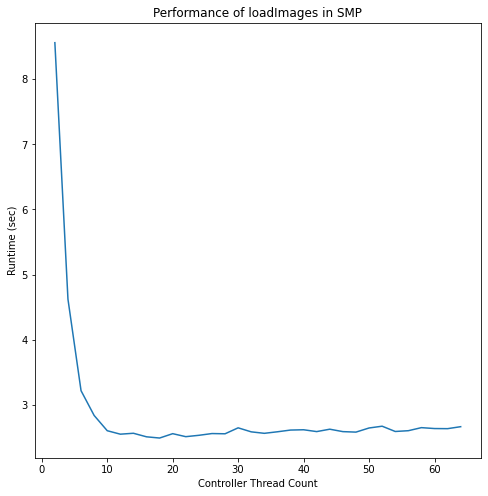

In [12]:
# Plot the performance
fig = tuner_results.plot_exec_times(fig_width = 8, fig_height = 8)

### Example - 2

Following example tunes CAS threads for loading natural images MPP mode.

In [6]:
tuner_results = CASThreadTuner.tune_thread_count(setup_function=setup, teardown_function=teardown, action_function=load_natural_images, iterations=3, objective_measure=Statistic.MINIMUM, controller_thread_range=range(8, 65, 8), worker_thread_range=range(4, 33, 4))

NOTE: Added action set 'image'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


In [7]:
# Print optimal thread count
print("Optimal thread count on controller node:", tuner_results._controller_optimal_thread_count)
print("Optimal thread count on worker node:", tuner_results._worker_optimal_thread_count)

Optimal thread count on controller node: 48
Optimal thread count on worker node: 4


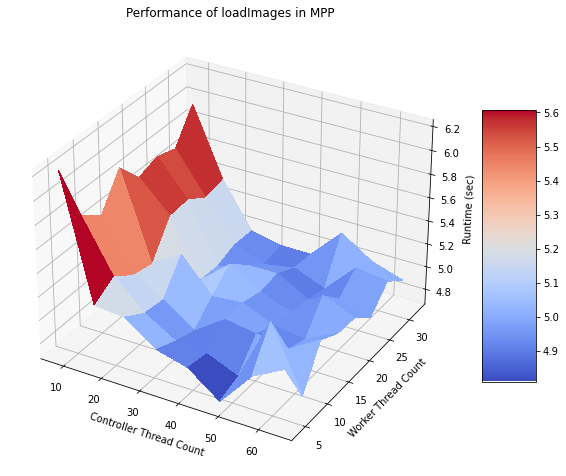

In [8]:
# Plot the performance
fig = tuner_results.plot_exec_times(fig_width = 10, fig_height = 10)

### Example - 3

Following example tunes CAS threads for loading DICOM series MPP mode.

In [23]:
tuner_results = CASThreadTuner.tune_thread_count(setup_function=setup, teardown_function=teardown, action_function=load_dicom_series, iterations=3, controller_thread_range=range(8, 65, 8), worker_thread_range=range(8, 65, 8))

NOTE: Added action set 'image'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


In [24]:
# Print optimal thread count
print("Optimal thread count on controller node:", tuner_results._controller_optimal_thread_count)
print("Optimal thread count on worker node:", tuner_results._worker_optimal_thread_count)

Optimal thread count on controller node: 8
Optimal thread count on worker node: 16


In [28]:
# Print performance statistic
print("Objective measure:",tuner_results._objective_measure)
print("\nMean of execution times:\n", tuner_results._mean_exec_times)
print("\nMedian of execution times:\n", tuner_results._median_exec_times)
print("\nMinimum of execution times:\n", tuner_results._minimum_exec_times)
print("\nMaximum of execution times:\n", tuner_results._maximum_exec_times)
print("\nStandard deviation of execution times:\n", tuner_results._stdev_exec_times)

Objective measure: Statistic.MEAN

Mean of execution times:
 [[10.1461  9.9523 10.3781 10.1078 10.3784 10.0941 10.4073 10.3146]
 [10.0662 12.4273 12.9801 13.0068 12.8268 12.9768 13.1387 12.9444]
 [13.2935 13.9826 13.8536 13.9511 13.952  13.864  14.0712 13.9017]
 [14.4154 14.9407 15.079  15.0225 15.7999 15.394  15.4748 15.0586]
 [14.1757 14.4884 14.8106 14.8116 14.7025 14.6707 14.8812 14.5678]
 [14.4272 14.9593 14.8007 14.7811 14.6903 14.6605 14.8066 14.7704]
 [14.3938 15.1639 14.8728 14.875  14.838  14.5378 14.9178 14.8689]
 [14.9248 15.4062 14.8943 14.8329 14.6944 14.8941 15.027  15.0602]]

Median of execution times:
 [[ 9.5916  9.8818 10.117  10.1684 10.1959 10.0987 10.3004 10.3142]
 [ 9.8024 12.5826 13.0059 12.9394 12.7932 12.8826 13.1191 12.9245]
 [13.2183 13.9374 13.8624 13.9478 13.9378 13.815  14.09   13.8803]
 [14.3544 14.7941 15.1214 15.0953 15.856  15.3113 15.371  15.1728]
 [14.1751 14.5341 14.8276 14.8201 14.6511 14.6908 14.9028 14.5569]
 [14.4249 14.8578 14.8149 14.6778 14.6

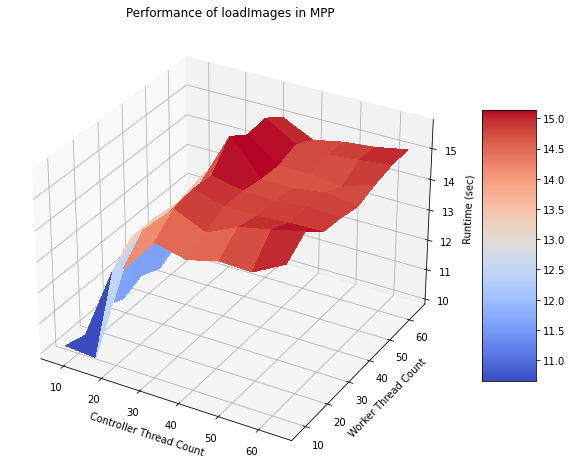

In [29]:
# Plot the performance
fig = tuner_results.plot_exec_times(fig_width = 10, fig_height = 10)